In [1]:
import os
os.chdir('C:/Users/davietbe/Documents/develop')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepberry.src.openalea.deepberry.temporal import distance_matrix, points_sets_alignment

# 1. Loads a time-series of segmentation outputs

### (Images: Phenoarch 2021 - plantid 7794 - angle 120° - half of tasks)

In [3]:
fd = 'deepberry/examples/data/temporal'
segmentation_time_series = {int(f.split('.csv')[0]): pd.read_csv(fd + '/' + f) for f in os.listdir(fd)}

# 2. Computes the distance matrix of the time-series

## Computes point-set registrations for couples of time-points (i, j). Each point set contains the center positions of the ellipses segmented at the corresponding time-point. Each registration gives a distance D between the two time-points, which is stored in a matrix.

In [4]:
points_sets = [np.array(s[['ell_x', 'ell_y']]) for s in segmentation_time_series.values()]
M = distance_matrix(points_sets)

## Displays the matrix

Text(0, 0.5, '$j$')

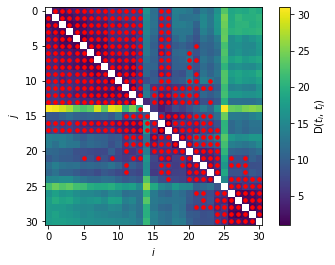

In [5]:
M2 = M[:, :, 0].copy()
for i in range(len(M)):
    for j in range(len(M)):
        if i < j:
            M2[i, j] = np.min(M[i, j][[0, 2]])
        elif i > j:
            M2[i, j] = np.min(M[i, j][[1, 2]])

plt.figure()
plt.imshow(M2)
set_threshold = 8
plt.plot(np.where(M2 < set_threshold)[0], np.where(M2 < set_threshold)[1], 'r.', markersize=7)
cb = plt.colorbar()
cb.set_label('D($t_i$, $t_j$)')
plt.xlabel('$i$')
plt.ylabel('$j$')

# 3. Berry tracking

## Tracks berry center positions over the time-series, using the distance matrix 

In [22]:
berry_ids = points_sets_alignment(points_sets=points_sets, dist_mat=M)

tracking = []
for k, (t, ellipse_set) in enumerate(segmentation_time_series.items()):
    ellipse_set.loc[:, 'berryid'] = berry_ids[k]
    ellipse_set.loc[:, 'task'] = k
    ellipse_set.loc[:, 't'] = t
    tracking.append(ellipse_set)
tracking = pd.concat(tracking)
tracking['t'] = (tracking['t'] - np.min(tracking['t'])) / 3600 / 24

## Displays the results, for 5 random time-points. Segmented ellipses are represented as points located at their center position. Each berry tracked is represented by the same color over time. Arrows correspond to segmented ellipses that haven't been tracked.

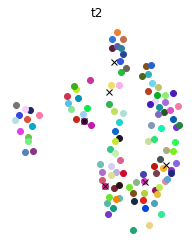

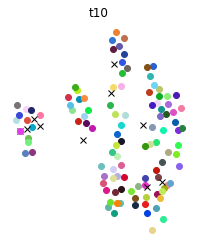

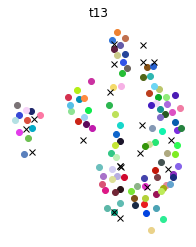

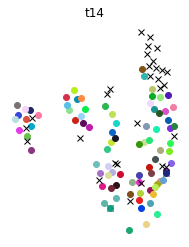

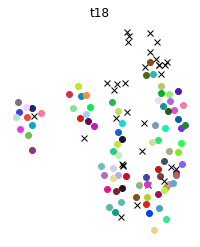

In [23]:
colors = [np.random.randint(0, 255 + 1, 3) for _ in range(1 + max(tracking['berryid']))]
colors.append(np.array([0, 0, 0]))
for k, task in enumerate(sorted(np.random.choice(tracking['task'].unique(), 5, replace=False))):
    plt.figure()
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('t{}'.format(task))
    s = tracking[tracking['task'] == task]
    for _, ell in s.iterrows():
        plt.plot(ell['ell_x'], ell['ell_y'], 
                 marker='o' if ell['berryid'] != -1 else 'x', 
                 color=colors[int(ell['berryid'])]/255)

# 4. Extraction of volume and color kinetics for one berry

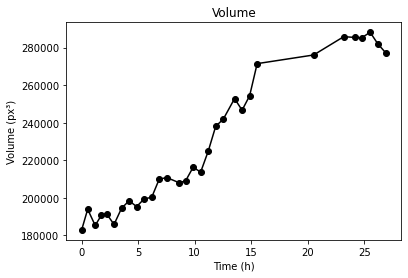

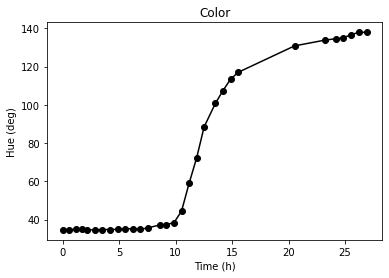

In [27]:
berryid = tracking[tracking['berryid'] != -1].groupby('berryid').size().sort_values().index[-3]

s = tracking[tracking['berryid'] == berryid]

plt.figure()
plt.title('Volume')
plt.xlabel('Time (h)')
plt.ylabel('Volume (px³)')
plt.plot(s['t'], s['volume'], 'k-o')
plt.figure()
plt.xlabel('Time (h)')
plt.ylabel('Hue (deg)')
plt.title('Color')
plt.plot(s['t'], s['hue_scaled'], 'k-o')